#Loading libraries

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import plotly.express as px

#Exploring Data Frame


In [2]:
df = pd.read_csv('/content/telecom_clean.csv')
df.isnull().sum()

customer_id                          0
gender                               0
age                                  0
married                              0
number_of_dependents                 0
city                                 0
zip_code                             0
latitude                             0
longitude                            0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data           

In [3]:
df.columns

Index(['customer_id', 'gender', 'age', 'married', 'number_of_dependents',
       'city', 'zip_code', 'latitude', 'longitude', 'number_of_referrals',
       'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn_category', 'churn_reason',
       'population'],
      dtype='object')

In [36]:
df.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,...,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason,population,clusters
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,593.30,0.00,0,381.51,974.81,Stayed,no_churn,no_churn,4498,1
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,542.40,38.33,10,96.21,610.28,Stayed,no_churn,no_churn,31297,1
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,62069,1
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,46677,1
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,42853,1


#Shaping Data for Machine Learning

In [4]:
df_dropped = df.drop(columns = ['customer_id', 'latitude', 'longitude', 'customer_status', 'churn_category', 'churn_reason', 'city'])


In [11]:
services = ['online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data']

for service in services:
  df_dropped.loc[df[service] == 'Yes', service] = 1
  df_dropped.loc[df[service] == 'No', service] = 0

df_dropped['sum_of_services'] = df_dropped[services].sum(axis=1)

df_dropped.drop(columns=services, inplace=True)

#Scaling and encoding data

In [17]:
num_columns = df_dropped.select_dtypes(include = ['int64', 'float64']).columns

non_num_columns = df_dropped.select_dtypes(exclude = ['int64', 'float64']).columns

In [18]:
scalar = StandardScaler()

df_scaled = pd.DataFrame(scalar.fit_transform(df_dropped[num_columns]), columns = num_columns)
df_scaled = df_scaled.drop(columns = 'zip_code')

In [19]:
encoder = OneHotEncoder()
encoded_list = pd.DataFrame(encoder.fit_transform(df_dropped[non_num_columns]).toarray())

df_merged = df_scaled.merge(encoded_list, left_index=True, right_index=True)


#Checking inertia to decide amount of Clusters

In [20]:
inertia=[]
df_merged.columns = df_merged.columns.astype(str)
for i in range(2,20):
  kmeans = KMeans(n_clusters=i, n_init=10).fit(df_merged)
  inertia.append([i, kmeans.inertia_])

inertia = pd.DataFrame(inertia, columns=['nb_clusters', 'inertia'])
px.line(inertia,x = 'nb_clusters', y = 'inertia')

#DBSCAN - Checking if its usable for this project

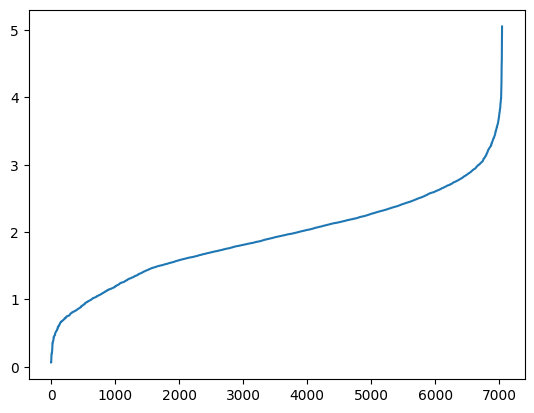

In [21]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_merged)
distances, indices = neighbors_fit.kneighbors(df_merged)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [24]:
dbscan = DBSCAN(eps=3, min_samples = 20).fit(df_merged)
dbscan_labels = dbscan.labels_
dbscan_labels

for i in range(-1,max(dbscan_labels)+1):
  print(i, list(dbscan.labels_).count(i))

-1 1168
0 5875


#KMeans on 3 clusters and checking Churners on each cluster

In [26]:
kmeans = KMeans(n_clusters=3, n_init=10).fit(df_merged)


KMeans(n_clusters=3, n_init=10)

In [28]:
df['clusters'] = kmeans.labels_


In [37]:
for i in range (df['clusters'].min(), df['clusters'].max()+1):
  print('Churned percentage for cluster', i , 'is', len(df[(df['clusters']==i) & (df['customer_status']=='Churned')])/len(df[df['clusters']==i]))


Churned percentage for cluster 0 is 0.1461038961038961
Churned percentage for cluster 1 is 0.4298088410991637
Churned percentage for cluster 2 is 0.07472384665367121


In [41]:
pd.DataFrame(kmeans.cluster_centers_, columns = df_merged.columns)

,age,number_of_dependents,number_of_referrals,tenure_in_months,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_refunds,total_extra_data_charges,...,18,19,20,21,22,23,24,25,26,27
0,0.049506,0.065311,0.399695,1.038650,0.231225,0.344363,0.823478,1.305332,0.054904,0.178132,...,0.638812,-2.581269e-15,0.215877,0.331012,0.453110,0.313370,0.686630,0.607707,0.372331,0.019963
1,0.069336,-0.177083,-0.292914,-0.633446,-0.209823,0.237452,0.103597,-0.512849,-0.018432,0.011019,...,0.494925,-2.747802e-15,0.782388,0.138806,0.078806,0.331045,0.668955,0.640000,0.300597,0.059403
2,-0.220215,0.294053,0.078180,-0.074859,0.133106,-0.998844,-1.378051,-0.710617,-0.036723,-0.273300,...,0.000650,9.915530e-01,0.340481,0.241715,0.417804,0.706953,0.293047,0.296296,0.610786,0.092917
